In this notebook we'll try out estimation of a transfer function using both time-domain and frequency domain data to see how they behave compared to each other. We start by loading the relevant packages. 

In [1]:
using ControlSystems, ControlSystemIdentification

┌ Info: Precompiling ControlSystemIdentification [3abffc1c-5106-53b7-b354-a47bfc086282]
└ @ Base loading.jl:1278


Next, we define the system to be estimated
$$G_{test}(s) = \dfrac{12}{1.1s^2 + 0.0009s + 12}$$
This is a very lightly damped (resonant), second-order system.
We also discretize the system using ZoH and simulate some data from it with a Gaussian input $u$.

In [2]:
Gtest = tf([12], [1.1, 0.0009, 12]) # True system
h     = 0.01                        # Sample time
u     = randn(10000)
Gd    = c2d(Gtest, h)
y,x,t = lsim(Gd, u);

Next, we construct an `IdData` object and estimate the transfer function using a spectral method

In [3]:
d = iddata(y', u', h)
H = tfest(d, 0.05)[1]

FRD{LinRange{Float64},Array{Complex{Float64},1}}(range(0.0, stop=314.1592653589793, length=10000), Complex{Float64}[1.0395964628689274 + 0.0im, 1.036644270438834 - 0.0119814511991472im, 1.0289572012122559 - 0.021057078726853456im, 1.0190658707059392 - 0.02584681338626816im, 1.009305450753809 - 0.02647692738464104im, 1.0012494207721907 - 0.023779683263557755im, 0.995859991960348 - 0.018818582571236614im, 0.9935972599942832 - 0.012806665688665947im, 0.9942826474883528 - 0.0070078045968635936im, 0.9970223491857262 - 0.0023790573705895434im  …  0.0010664837718650888 - 5.2007825278224094e-5im, 0.0011137914456125072 - 0.00035365264400887074im, 0.0010366909939348642 - 0.0006772597111273144im, 0.000822096544220578 - 0.0009608529399062423im, 0.0004933764327726696 - 0.0011402886033456843im, 0.00010807629647367605 - 0.0011752553482966472im, -0.0002654370066166919 - 0.0010640582003707245im, -0.0005735189398016562 - 0.0008354218684345355im, -0.0007867744279085353 - 0.0005289112674312065im, -0.00089

The spectral method yields a nonparametric estimate of the transfer function, i.e., the value of the transfer function for each frequency in a frequency vector. To obtain a parametric (rational) transfer function, we now call the function `arx` to estimate a (discrete time) model from time-domain data and the function `tfest` to obtain a model from the frequency-domain data. We use the function `d2c` to convert the estimated ARX model from discrete time to continuous time to allow us to compare the estimated poles.

In [4]:
G0 = tf([10], [1.0, 0.01, 10]) # initial guess
Gf = tfest(H, G0)              # Provide an initial guess for frequency domain
Gt = arx(d, 2, 1) |> d2c       # Provide the model order for time domain
Gf, Gt

Iter     Function value   Gradient norm 
     0     2.000340e-04     5.055316e-04
 * time: 0.0069539546966552734
     1     1.993929e-04     2.329294e-04
 * time: 1.180901050567627
     2     1.480085e-04     6.324656e-05
 * time: 1.3211960792541504
     3     1.439263e-04     9.364421e-05
 * time: 1.3688349723815918
     4     1.437811e-04     1.090217e-04
 * time: 1.4091711044311523
     5     1.416988e-04     9.978589e-06
 * time: 1.4980220794677734
     6     1.416886e-04     9.911312e-06
 * time: 1.5468010902404785
     7     1.416881e-04     9.936194e-06
 * time: 1.5935680866241455
     8     1.402634e-04     5.228682e-05
 * time: 1.729119062423706
     9     1.387165e-04     1.303989e-05
 * time: 1.787174940109253
    10     1.386795e-04     9.304605e-07
 * time: 1.829442024230957
    11     1.386791e-04     3.465796e-09
 * time: 1.8864948749542236


(TransferFunction{Continuous,ControlSystems.SisoRational{Float64}}
                        10.32506886469284
-----------------------------------------------------------------
0.8825792466629764*s^2 + 0.3494217676540427*s + 9.686341997336534

Continuous-time transfer function model, TransferFunction{Continuous,ControlSystems.SisoRational{Float64}}
    -0.027465402972057334*s + 5.4926099465486775
----------------------------------------------------
1.0*s^2 - 0.00324629473561518*s + 10.930643498740073

Continuous-time transfer function model)

We can inspect the error in the estimated poles of the system, and how well the static gain is estimated:

In [6]:
norm(pole(Gt)-pole(Gtest)), norm(pole(Gf)-pole(Gtest))

(0.0054336307936131015, 0.27943063192652257)

In [7]:
dcgain(Gtest)[], dcgain(Gt)[], dcgain(Gf)[]

(1.0, 0.5024964858822618, 1.0659409782900435)

It appears as if the time-domain method is better at locating the poles, which is expected since AR-model estimation is considered a spectral-estimation method with "super resolution". The static gain is better estimated by the frequency-domain method.

We can also plot the bode curves of the systems:

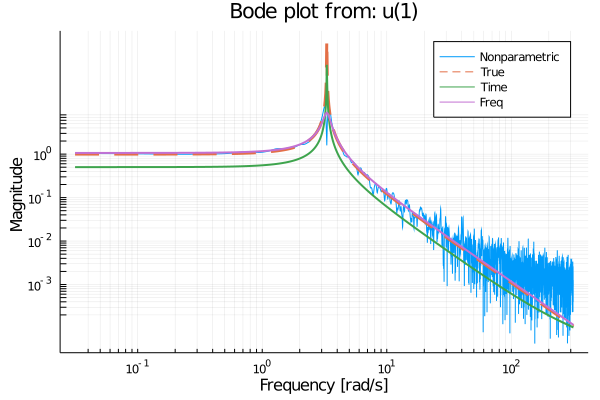

In [8]:
plot(H, lab="Nonparametric", legend=true)
bodeplot!(Gtest, H.w[2:end], lab="True", plotphase=false, l=(3,:dash))
bodeplot!(Gt,    H.w[2:end], lab="Time", plotphase=false, l=(2,))
bodeplot!(Gf,    H.w[2:end], lab="Freq", plotphase=false, l=(2,))